<a href="https://colab.research.google.com/github/Rahul-dsml/Myprojects/blob/main/News_Classification_using_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# News Classification using BERT 

In [80]:
# Checking the GPU configuration
!nvidia-smi

Sat Jan 15 18:56:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    33W /  70W |   8624MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [81]:
import tensorflow as tf
print(tf.version.VERSION)

2.7.0


In [82]:
#!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

In [83]:
#!pip install -Uqr models/official/requirements.txt

### Import relevant libraries

In [84]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

In [85]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.7.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


## Reading the dataset

In [86]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('/content/drive/MyDrive/NLP/BBC News Train.csv')
df.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [87]:
df['Category'].value_counts()

sport            346
business         336
politics         274
entertainment    273
tech             261
Name: Category, dtype: int64

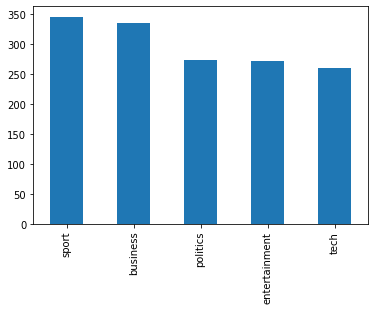

In [88]:
df['Category'].value_counts().plot(kind='bar');

In [89]:
df.shape

(1490, 3)

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


In [91]:
df['Category'].unique()

array(['business', 'tech', 'politics', 'sport', 'entertainment'],
      dtype=object)

In [92]:
labels= {'business': 1,
         'tech': 2,
         'politics':3,
         'sport': 4,
         'entertainment':5}
def convert_target(x):
  for k,v in labels.items():
    if x==k:
      return v
df['target']= df['Category'].apply(convert_target)

In [93]:
df.head(20)

,ArticleId,Text,Category,target
0,1833,worldcom ex-boss launches defence lawyers defe...,business,1
1,154,german business confidence slides german busin...,business,1
2,1101,bbc poll indicates economic gloom citizens in ...,business,1
3,1976,lifestyle governs mobile choice faster bett...,tech,2
4,917,enron bosses in $168m payout eighteen former e...,business,1
5,1582,howard truanted to play snooker conservative...,politics,3
6,651,wales silent on grand slam talk rhys williams ...,sport,4
7,1797,french honour for director parker british film...,entertainment,5
8,2034,car giant hit by mercedes slump a slump in pro...,business,1
9,1866,fockers fuel festive film chart comedy meet th...,entertainment,5


### Creating training and validation datasets using SkLearn library

In [94]:
df_train, validation= train_test_split(df, train_size=0.8, random_state=42, stratify=df['Category'].values)

In [95]:
df_train.shape

(1192, 4)

In [96]:
validation.shape

(298, 4)

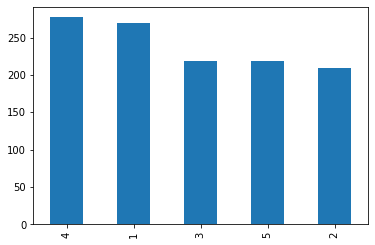

In [97]:
df_train['target'].value_counts().plot(kind='bar');

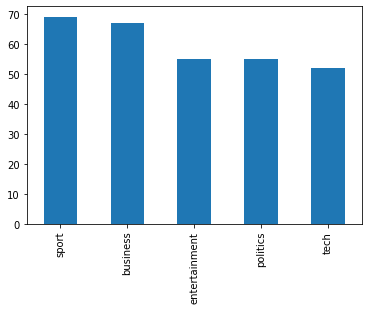

In [98]:
validation['Category'].value_counts().plot(kind='bar');

In [99]:
with tf.device('/cpu:0'):
  train_data= tf.data.Dataset.from_tensor_slices((df_train['Text'].values, df_train['target'].values))
  valid_data= tf.data.Dataset.from_tensor_slices((validation['Text'].values, validation['target'].values))

  for text, category in train_data.take(3):
    print(category)
    print(text)
    

tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(b'winter freeze keeps oil above $50 oil prices carried on rising on wednesday after cold weather on both sides of the north atlantic pushed us crude prices to four-month highs.  freezing temperatures and heavy snowfalls took crude oil prices past $50 a barrel on tuesday for the first time since november. declines in the dollar have also contributed to the rising oil price. us crude was trading at $51.39 at 0710 gmt in asian electronic trade on wednesday. a barrel of us crude oil closed up $2.80 at $51.15 in new york on tuesday. opec members said on tuesday that  given such high prices  the cartel saw no reason to cut its output.  although below last year s peak of $55.67 a barrel  which was reached in october  prices are now well above 2004 s average of $41.48. brent crude also rose in london trading  adding $1.89 to $48.62 at the close.  much of western europe and the north east of america has been shivering under unseasonably low temperat

### Downloading pre-trained BERT model

In [100]:
x= df_train.shape[0]
y= df_train.shape[0]//8
print(x, y, 8*y)

1192 149 1192


In [101]:
label_list = [x for x in df_train.target.unique()]
max_seq_length= 128
batch_size=32

bert_layer= hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2', trainable=True)
vocab_file= bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case= bert_layer.resolved_object.do_lower_case.numpy()
tokenizer= tokenization.FullTokenizer(vocab_file, do_lower_case)

In [102]:
tokenizer.wordpiece_tokenizer.tokenize("i like political and sports news")

['i', 'like', 'political', 'and', 'sports', 'news']

In [103]:
tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize("i like political and sports news"))

[1045, 2066, 2576, 1998, 2998, 2739]

### Converting and Preprocessing the text

In [104]:
# This provides a function to convert row to input features and label

def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  example = classifier_data_lib.InputExample(guid= None, 
                                             text_a=text.numpy(),
                                             label= label.numpy())
  feature= classifier_data_lib.convert_single_example(0, example, label_list, max_seq_length, tokenizer)
  
  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

In [105]:
def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text, label],
                                                                Tout= [tf.int32, tf.int32, tf.int32, tf.int32])
  
  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([])

  x= {'input_word_ids': input_ids,
      'input_mask': input_mask,
      'input_type_ids': segment_ids}

  return (x, label_id)

### Creating tensorflow pipeline wuth tf.data

In [106]:
with tf.device('/cpu: 0'):
  train_data= (train_data.map(to_feature_map, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(100).batch(32, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE))

  valid_data= (valid_data.map(to_feature_map, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(100).batch(32, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE))




In [107]:
train_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [108]:
valid_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

## Building a model over BERT Layer

In [109]:
# Building the model
def create_model():
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype= tf.int32, name= "input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype= tf.int32, name= "input_mask")
  input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype= tf.int32, name= "input_type_ids")

  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])
  drop= tf.keras.layers.Dropout(0.2)(pooled_output)
  output = tf.keras.layers.Dense(5, activation='softmax', name= 'output')(drop)

  model = tf.keras.Model(
      inputs= {
          'input_word_ids' : input_word_ids, 
          'input_mask' : input_mask,
          'input_type_ids': input_type_ids
      },
      outputs= output)
  return model


In [110]:
model= create_model()
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 128)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 keras_layer_3 (KerasLayer)     [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 128, 768)]                'input_mask[0][0]',       

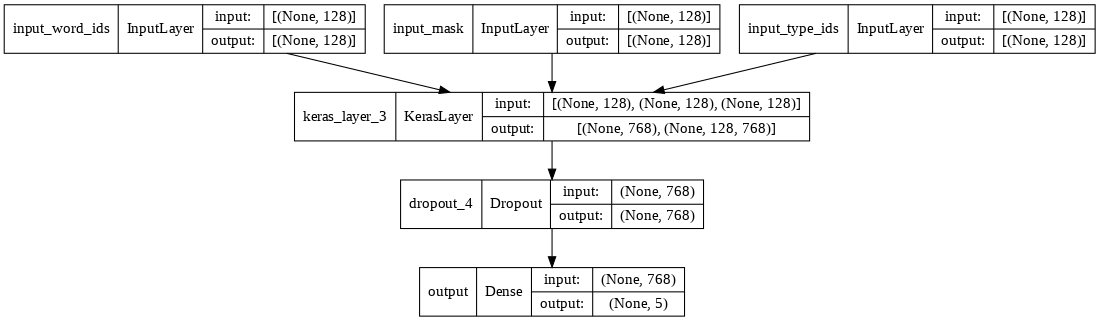

In [111]:
tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=76)

## Training

In [112]:
epochs=5
history= model.fit(train_data, validation_data=valid_data, epochs=epochs, verbose=1)

Epoch 1/5
37/37 [==============================] - 51s 1s/step - loss: 0.6277 - sparse_categorical_accuracy: 0.7677 - val_loss: 0.1775 - val_sparse_categorical_accuracy: 0.9340
Epoch 2/5
37/37 [==============================] - 37s 962ms/step - loss: 0.1142 - sparse_categorical_accuracy: 0.9721 - val_loss: 0.1110 - val_sparse_categorical_accuracy: 0.9722
Epoch 3/5
37/37 [==============================] - 37s 976ms/step - loss: 0.0546 - sparse_categorical_accuracy: 0.9856 - val_loss: 0.1600 - val_sparse_categorical_accuracy: 0.9722
Epoch 4/5
37/37 [==============================] - 37s 972ms/step - loss: 0.0735 - sparse_categorical_accuracy: 0.9823 - val_loss: 0.2234 - val_sparse_categorical_accuracy: 0.9653
Epoch 5/5
37/37 [==============================] - 37s 972ms/step - loss: 0.0620 - sparse_categorical_accuracy: 0.9856 - val_loss: 0.1203 - val_sparse_categorical_accuracy: 0.9792


In [113]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

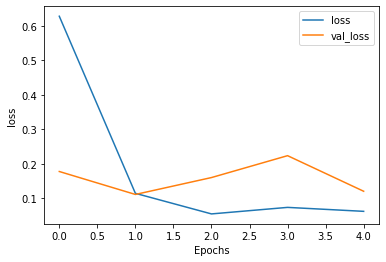

In [114]:
plot_graphs(history, 'loss')

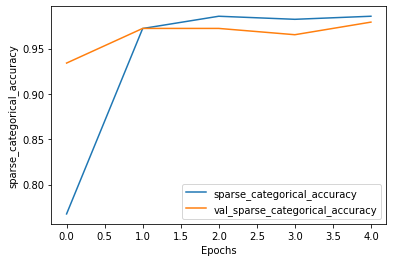

In [115]:
plot_graphs(history, 'sparse_categorical_accuracy')